In [17]:
import sqlite3
import pandas as pd
import os
import glob

csv_folder_path = "./data"  # 包含所有22个CSV文件的文件夹路径
db_path = "./esi_rankings.db"  # 希望生成的数据库文件的存放路径和名称

if os.path.exists(db_path):
    os.remove(db_path)
    print(f"已删除旧的数据库文件: {db_path}")

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

create_table_sql = """
CREATE TABLE IF NOT EXISTS esi_rankings (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    research_field TEXT NOT NULL,
    rank INTEGER,
    institution TEXT NOT NULL,
    country_region TEXT,
    documents INTEGER,
    cites INTEGER,
    cites_per_paper REAL,
    top_papers INTEGER
);
"""
cursor.execute(create_table_sql)
print(f"数据库 '{db_path}' 和数据表 'esi_rankings' 已成功创建。")

csv_files = glob.glob(os.path.join(csv_folder_path, "*.csv"))

if not csv_files:
    print(f"警告：在文件夹 '{csv_folder_path}' 中没有找到任何CSV文件。请检查路径。")
else:
    for file_path in csv_files:
        file_encoding = "latin-1"

        with open(file_path, "r", encoding=file_encoding) as f:
            first_line = f.readline()

        try:
            field_value = (
                first_line.split("Filter Value(s):")[1].split("Show:")[0].strip()
            )
            print(f"正在处理文件: {os.path.basename(file_path)}，学科: {field_value}")

            df = pd.read_csv(file_path, header=1, encoding=file_encoding)

            # 重命名列以匹配数据库的Schema
            df.rename(
                columns={
                    "Unnamed: 0": "rank",
                    "Institutions": "institution",
                    "Countries/Regions": "country_region",
                    "Web of Science Documents": "documents",
                    "Cites": "cites",
                    "Cites/Paper": "cites_per_paper",
                    "Top Papers": "top_papers",
                },
                inplace=True,
            )

            # 关键清洗步骤：移除机构名称为空的无效行 (例如CSV末尾的空行)
            initial_rows = len(df)
            df.dropna(subset=["institution"], inplace=True)

            # --- d. 将清洗后的数据写入数据库 ---
            if not df.empty:
                df["research_field"] = field_value
                # 筛选并排序 DataFrame 的列，以确保与数据库表结构一致
                final_df = df[
                    [
                        "research_field",
                        "rank",
                        "institution",
                        "country_region",
                        "documents",
                        "cites",
                        "cites_per_paper",
                        "top_papers",
                    ]
                ]
                # 使用 'append' 模式将数据追加到表中
                final_df.to_sql("esi_rankings", conn, if_exists="append", index=False)
                print(f"✅ 成功导入 {len(final_df)} 条 '{field_value}' 学科的数据。")

        except Exception as e:
            print(f"❌ 处理文件 {os.path.basename(file_path)} 时发生错误: {e}")

# --- 4. 提交更改并关闭数据库连接 ---
conn.commit()
conn.close()
print("\n🎉 所有数据导入完成！数据库 'esi_rankings.db' 已准备就绪。")

已删除旧的数据库文件: ./esi_rankings.db
数据库 './esi_rankings.db' 和数据表 'esi_rankings' 已成功创建。
正在处理文件: AGRICULTURAL SCIENCES.csv，学科: AGRICULTURAL SCIENCES
✅ 成功导入 1381 条 'AGRICULTURAL SCIENCES' 学科的数据。
正在处理文件: BIOLOGY & BIOCHEMISTRY.csv，学科: BIOLOGY & BIOCHEMISTRY
✅ 成功导入 1649 条 'BIOLOGY & BIOCHEMISTRY' 学科的数据。
正在处理文件: CHEMISTRY.csv，学科: CHEMISTRY
✅ 成功导入 2141 条 'CHEMISTRY' 学科的数据。
正在处理文件: CLINICAL MEDICINE.csv，学科: CLINICAL MEDICINE
✅ 成功导入 6754 条 'CLINICAL MEDICINE' 学科的数据。
正在处理文件: COMPUTER SCIENCE.csv，学科: COMPUTER SCIENCE
✅ 成功导入 863 条 'COMPUTER SCIENCE' 学科的数据。
正在处理文件: ECONOMICS & BUSINESS.csv，学科: ECONOMICS & BUSINESS
✅ 成功导入 543 条 'ECONOMICS & BUSINESS' 学科的数据。
正在处理文件: ENGINEERING.csv，学科: ENGINEERING
✅ 成功导入 2787 条 'ENGINEERING' 学科的数据。
正在处理文件: ENVIRONMENT ECOLOGY.csv，学科: ENVIRONMENT/ECOLOGY
✅ 成功导入 2066 条 'ENVIRONMENT/ECOLOGY' 学科的数据。
正在处理文件: GEOSCIENCES.csv，学科: GEOSCIENCES
✅ 成功导入 1175 条 'GEOSCIENCES' 学科的数据。
正在处理文件: IMMUNOLOGY.csv，学科: IMMUNOLOGY
✅ 成功导入 1177 条 'IMMUNOLOGY' 学科的数据。
正在处理文件: MATERIALS SCIENCE.csv，学科:

In [18]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pycountry


def execute_query(db_path, query):
    """
    功能：连接指定的SQLite数据库，执行一条SQL查询语句。
    参数：
        db_path (str): 数据库文件的路径。
        query (str): 需要执行的SQL查询字符串。
    返回：
        pandas.DataFrame: 包含查询结果的DataFrame。如果出错则返回None。
    """
    try:
        with sqlite3.connect(db_path) as conn:
            df = pd.read_sql_query(query, conn)
            return df
    except Exception as e:
        print(f"执行查询时发生错误: {e}")
        return None


def get_iso_alpha_3(country_name):
    """
    功能：将国家/地区名称转换为标准的ISO 3166-1 alpha-3三字符代码。
    说明：内置了一个手动映射表来处理数据库中的非标准名称。
    参数：
        country_name (str): 数据库中的国家/地区名称。
    返回：
        str: 对应的三字符ISO代码，如果找不到则返回None。
    """
    # 手动映射表，处理 'pycountry' 无法直接识别的特殊名称
    manual_map = {
        "CHINA MAINLAND": "CHN",
        "USA": "USA",
        "ENGLAND": "GBR",  # 英格兰、苏格兰等均属于联合王国 (GBR)
        "SCOTLAND": "GBR",
        "WALES": "GBR",
        "NORTH IRELAND": "GBR",
        "GERMANY (FED REP GER)": "DEU",
        "SOUTH KOREA": "KOR",
        "RUSSIA": "RUS",
        "IRAN": "IRN",
    }

    if country_name in manual_map:
        return manual_map[country_name]

    try:
        # 尝试使用pycountry的模糊搜索功能来查找匹配项
        return pycountry.countries.search_fuzzy(country_name)[0].alpha_3
    except (LookupError, AttributeError):
        # 如果找不到任何匹配，则返回None
        return None


# --- 全局设置 ---
# 定义数据库文件路径，后续所有单元格都将使用此变量
DATABASE_FILE = "esi_rankings.db"
print("✅ 环境准备就绪，核心函数已定义。")

✅ 环境准备就绪，核心函数已定义。


In [19]:
universities_to_compare = [
    "EAST CHINA NORMAL UNIV",
    "PEKING UNIV",
    "TSINGHUA UNIV",
    "FUDAN UNIV",
    "TONGJI UNIV",
    "SHANGHAI JIAO TONG UNIV",
]

all_rankings_data = []
print("正在从数据库中查询指定大学的排名数据...")

for university in universities_to_compare:
    query = f"SELECT research_field, rank FROM esi_rankings WHERE institution LIKE '%{university}%'"
    df = execute_query(DATABASE_FILE, query)
    if df is not None and not df.empty:
        df["institution"] = university  # 添加大学名称列用于分组
        if university == universities_to_compare[0]:
            print(df)
        all_rankings_data.append(df)

正在从数据库中查询指定大学的排名数据...
                  research_field  rank             institution
0          AGRICULTURAL SCIENCES   845  EAST CHINA NORMAL UNIV
1         BIOLOGY & BIOCHEMISTRY   721  EAST CHINA NORMAL UNIV
2                      CHEMISTRY    90  EAST CHINA NORMAL UNIV
3              CLINICAL MEDICINE  2852  EAST CHINA NORMAL UNIV
4               COMPUTER SCIENCE   207  EAST CHINA NORMAL UNIV
5                    ENGINEERING   317  EAST CHINA NORMAL UNIV
6            ENVIRONMENT/ECOLOGY   130  EAST CHINA NORMAL UNIV
7                    GEOSCIENCES   275  EAST CHINA NORMAL UNIV
8              MATERIALS SCIENCE   196  EAST CHINA NORMAL UNIV
9                    MATHEMATICS   115  EAST CHINA NORMAL UNIV
10  MOLECULAR BIOLOGY & GENETICS   867  EAST CHINA NORMAL UNIV
11       NEUROSCIENCE & BEHAVIOR   853  EAST CHINA NORMAL UNIV
12     PHARMACOLOGY & TOXICOLOGY  1064  EAST CHINA NORMAL UNIV
13                       PHYSICS   522  EAST CHINA NORMAL UNIV
14        PLANT & ANIMAL SCIENCE 

数据获取完毕，正在生成可视化图表...


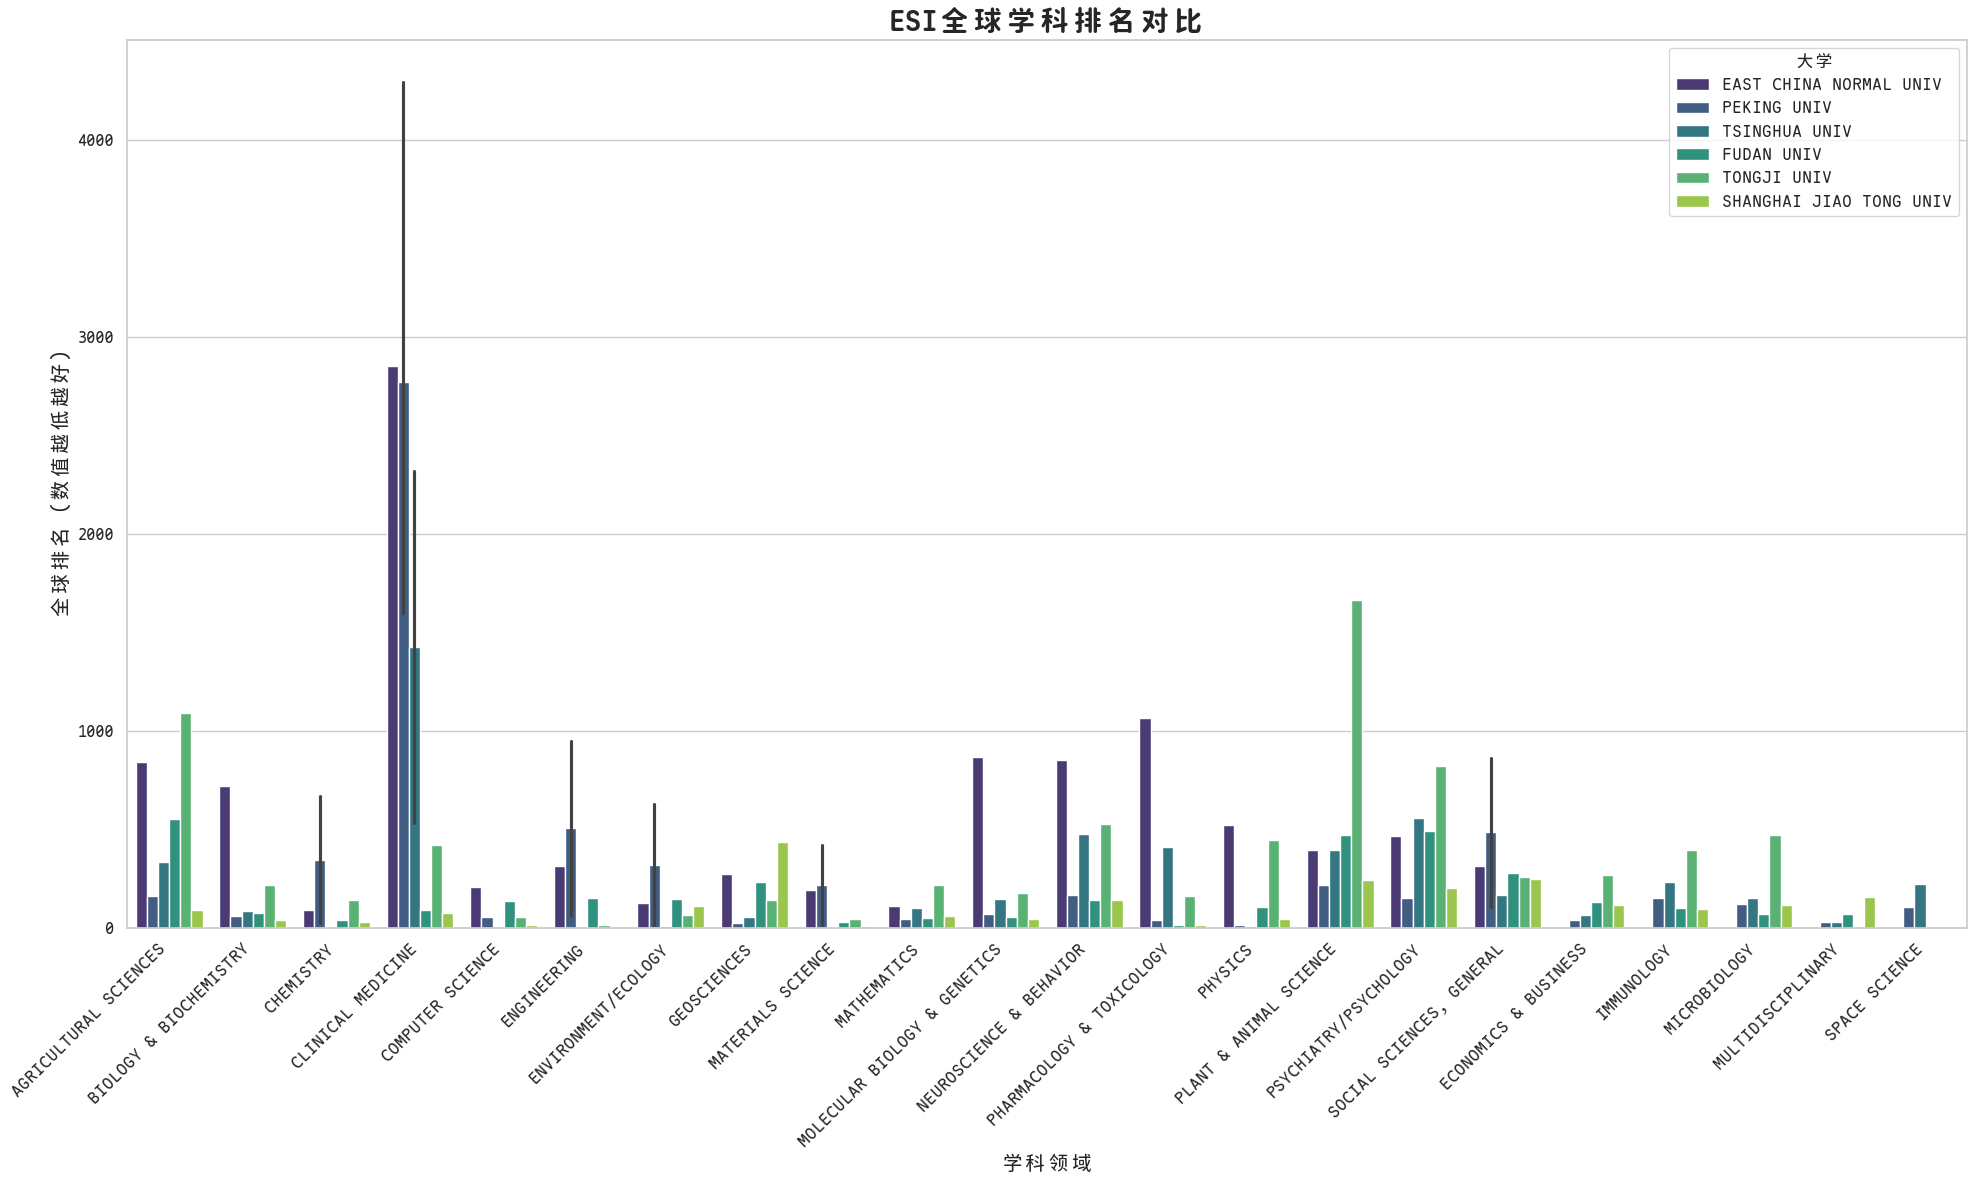

In [20]:
if all_rankings_data:
    # 将所有查询结果合并成一个DataFrame
    comparison_df = pd.concat(all_rankings_data, ignore_index=True)
    print("数据获取完毕，正在生成可视化图表...")

    # 使用Seaborn绘制分组条形图
    plt.figure(figsize=(20, 12))
    sns.set_theme(style="whitegrid", font="Maple Mono Normal NF CN")  # 设置支持中文的字体，如黑体
    plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

    sns.barplot(
        data=comparison_df,
        x="research_field",
        y="rank",
        hue="institution",
        palette="viridis",
    )

    # 美化图表
    plt.title("ESI全球学科排名对比", fontsize=20, weight="bold")
    plt.xlabel("学科领域", fontsize=14)
    plt.ylabel("全球排名 (数值越低越好)", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.legend(title="大学", fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("未能查询到任何指定大学的数据。")

In [21]:
print("--- 分析中国（大陆）大学在各学科的表现 ---")

# --- 分析角度1: 集体实力 ---
# 统计在每个学科中，有多少所中国大陆的大学进入了全球排名前100名。
# 这反映了中国在哪些学科领域具有广泛的高水平研究基础。
print("\n>>> 分析1: 各学科领域进入全球前100的中国（大陆）大学数量")
query_strength = """
    SELECT
      research_field AS '学科领域',
      COUNT(institution) AS '全球前100大学数量'
    FROM
      esi_rankings
    WHERE
      country_region = 'CHINA MAINLAND' AND rank <= 100
    GROUP BY
      research_field
    ORDER BY
      '全球前100大学数量' DESC;
"""
df_strength = execute_query(DATABASE_FILE, query_strength)
if df_strength is not None:
    # 使用 display() 函数在Jupyter中可以获得更好的表格格式化效果
    display(df_strength)
else:
    print("未能查询到相关数据。")


# --- 分析角度2: 顶尖实力 ---
# 找出在每个学科中，排名第一的中国大陆大学。
# 这反映了中国在各个学科领域的“领头羊”。
print("\n>>> 分析2: 各学科领域排名第一的中国（大陆）大学")
query_leaders = """
    SELECT
      research_field AS '学科领域',
      institution AS '排名第一的大学',
      rank AS '全球排名'
    FROM
      (
        SELECT
          research_field,
          institution,
          rank,
          ROW_NUMBER() OVER(PARTITION BY research_field ORDER BY rank ASC) as rn
        FROM
          esi_rankings
        WHERE
          country_region = 'CHINA MAINLAND'
      )
    WHERE
      rn = 1
    ORDER BY
      research_field ASC;
"""
df_leaders = execute_query(DATABASE_FILE, query_leaders)
if df_leaders is not None:
    display(df_leaders)
else:
    print("未能查询到相关数据。")

--- 分析中国（大陆）大学在各学科的表现 ---

>>> 分析1: 各学科领域进入全球前100的中国（大陆）大学数量


,学科领域,全球前100大学数量
0,SPACE SCIENCE,2
1,"SOCIAL SCIENCES, GENERAL",1
2,PLANT & ANIMAL SCIENCE,13
3,PHYSICS,10
4,PHARMACOLOGY & TOXICOLOGY,29
5,NEUROSCIENCE & BEHAVIOR,2
6,MULTIDISCIPLINARY,5
7,MOLECULAR BIOLOGY & GENETICS,9
8,MICROBIOLOGY,11
9,MATHEMATICS,24



>>> 分析2: 各学科领域排名第一的中国（大陆）大学


,学科领域,排名第一的大学,全球排名
0,AGRICULTURAL SCIENCES,CHINESE ACADEMY OF SCIENCES,1
1,BIOLOGY & BIOCHEMISTRY,CHINESE ACADEMY OF SCIENCES,3
2,CHEMISTRY,CHINESE ACADEMY OF SCIENCES,1
3,CLINICAL MEDICINE,SHANGHAI JIAO TONG UNIVERSITY,75
4,COMPUTER SCIENCE,CHINESE ACADEMY OF SCIENCES,1
5,ECONOMICS & BUSINESS,PEKING UNIVERSITY,44
6,ENGINEERING,CHINESE ACADEMY OF SCIENCES,1
7,ENVIRONMENT/ECOLOGY,CHINESE ACADEMY OF SCIENCES,1
8,GEOSCIENCES,CHINESE ACADEMY OF SCIENCES,1
9,IMMUNOLOGY,CHINESE ACADEMY OF SCIENCES,36


In [22]:
print("正在获取全球各学科数据用于生成世界地图...")
subject_data_query = """
    SELECT
      country_region,
      research_field,
      SUM(cites) AS total_cites
    FROM
      esi_rankings
    GROUP BY
      country_region, research_field;
"""
df_map = execute_query(DATABASE_FILE, subject_data_query)

if df_map is not None:
    print("数据预处理中：清洗、转换ISO代码...")
    df_map.dropna(subset=["country_region", "research_field"], inplace=True)
    df_map["total_cites"] = pd.to_numeric(
        df_map["total_cites"], errors="coerce"
    ).fillna(0)
    df_map["iso_alpha"] = df_map["country_region"].apply(
        get_iso_alpha_3
    )  # 调用单元格1的函数

    subjects = sorted(df_map["research_field"].unique())

    print("正在生成交互式地图...")
    fig = go.Figure()

    for subject in subjects:
        subject_df = df_map[df_map["research_field"] == subject]
        log_cites = np.log10(
            subject_df["total_cites"] + 1
        )  # 对引用数取对数，以优化颜色显示

        fig.add_trace(
            go.Choropleth(
                locations=subject_df["iso_alpha"],
                z=log_cites,
                text=subject_df["country_region"],
                customdata=subject_df["total_cites"],
                hovertemplate="<b>%{text}</b><br>总引用数: %{customdata:,.0f}<extra></extra>",
                colorscale="Plasma",
                visible=(subject == subjects[0]),  # 默认只显示第一个学科
            )
        )

    buttons = []
    for i, subject in enumerate(subjects):
        visibility_mask = [False] * len(subjects)
        visibility_mask[i] = True
        buttons.append(
            dict(label=subject, method="update", args=[{"visible": visibility_mask}])
        )

    fig.update_layout(
        title_text=f"<b>全球各学科学术影响力地图</b><br><i>请从下拉菜单中选择一个学科</i>",
        title_x=0.5,
        title_font_size=22,
        margin=dict(t=70, l=0, r=0, b=0),
        updatemenus=[
            dict(
                active=0,
                buttons=buttons,
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.1,  # 将菜单的x坐标设置在左侧10%的位置
                xanchor="left",  # x坐标的锚点是菜单的左边缘
                y=1.1,  # 将菜单的y坐标放在新的顶部空间内
                yanchor="top",  # y坐标的锚点是菜单的上边缘
            )
        ],
        geo=dict(
            showframe=False, showcoastlines=False, projection_type="natural earth"
        ),
    )

    fig.show()
else:
    print("未能获取用于生成地图的数据。")

正在获取全球各学科数据用于生成世界地图...
数据预处理中：清洗、转换ISO代码...
正在生成交互式地图...
